---
title: "Probability"
output: statsr:::statswithr_lab
---

<div id="instructions">  
Complete all **Exercises**, and submit answers to **Questions** on the Coursera 
platform.
</div>

## Hot Hands

Basketball players who make several baskets in succession are described as 
having a *hot hand*. Fans and players have long believed in the hot hand 
phenomenon, which refutes the assumption that each shot is independent of the 
next. However, [a 1985 paper](http://www.sciencedirect.com/science/article/pii/0010028585900106) by Gilovich, Vallone, and Tversky collected evidence
that contradicted this belief and showed that successive shots are independent 
events. This paper started a great controversy that continues to this day, as you can 
see by Googling *hot hand basketball*.

We do not expect to resolve this controversy today. However, in this lab we'll 
apply one approach to answering questions like this. The goals for this lab are 
to (1) think about the effects of independent and dependent events, (2) learn 
how to simulate shooting streaks in R, and (3) to compare a simulation to actual
data in order to determine if the hot hand phenomenon appears to be real.

## Getting Started

### Load packages

In this lab we will explore the data using the `dplyr` package and visualize it 
using the `ggplot2` package for data visualization. The data can be found in the
companion package for this course, `statsr`.

Let's load the packages.


In [38]:
library(statsr)
library(dplyr)
library(ggplot2)

### Data

Our investigation will focus on the performance of one player: Kobe Bryant of 
the Los Angeles Lakers. His performance against the Orlando Magic in the 2009 
NBA finals earned him the title *Most Valuable Player* and many spectators 
commented on how he appeared to show a hot hand. Let's load some necessary files
that we will need for this lab.

In [39]:
data(kobe_basket)

In [40]:
str(kobe_basket)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	133 obs. of  6 variables:
 $ vs         : Factor w/ 1 level "ORL": 1 1 1 1 1 1 1 1 1 1 ...
 $ game       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ quarter    : Factor w/ 5 levels "1","1OT","2",..: 1 1 1 1 1 1 1 1 1 3 ...
 $ time       : Factor w/ 116 levels "00:00.0","00:00.5",..: 114 109 102 100 96 85 64 21 11 91 ...
 $ description: Factor w/ 80 levels "Bryant 3pt Shot: Made (16 PTS) Assist: Bynum (1 AST)  ",..: 40 78 75 27 44 78 52 62 79 45 ...
 $ shot       : chr  "H" "M" "M" "H" ...


This data frame contains 133 observations and 6 variables, where every
row records a shot taken by Kobe Bryant. The `shot` variable in this dataset
indicates whether the shot was a hit (`H`) or a miss (`M`).

Just looking at the string of hits and misses, it can be difficult to gauge 
whether or not it seems like Kobe was shooting with a hot hand. One way we can 
approach this is by considering the belief that hot hand shooters tend to go on 
shooting streaks. For this lab, we define the length of a shooting streak to be 
the *number of consecutive baskets made until a miss occurs*.

For example, in Game 1 Kobe had the following sequence of hits and misses from 
his nine shot attempts in the first quarter:

\[ \textrm{H M | M | H H M | M | M | M} \]

You can verify this by viewing the first 8 rows of the data in the data viewer.

In [41]:
head(kobe_basket, 8)

vs,game,quarter,time,description,shot
<fct>,<int>,<fct>,<fct>,<fct>,<chr>
ORL,1,1,9:47,Kobe Bryant makes 4-foot two point shot,H
ORL,1,1,9:07,Kobe Bryant misses jumper,M
ORL,1,1,8:11,Kobe Bryant misses 7-foot jumper,M
ORL,1,1,7:41,Kobe Bryant makes 16-foot jumper (Derek Fisher assists),H
ORL,1,1,7:03,Kobe Bryant makes driving layup,H
ORL,1,1,6:01,Kobe Bryant misses jumper,M
ORL,1,1,4:07,Kobe Bryant misses 12-foot jumper,M
ORL,1,1,0:52,Kobe Bryant misses 19-foot jumper,M


Within the nine shot attempts, there are six streaks, which are separated by a 
"|" above. Their lengths are one, zero, two, zero, zero, zero (in order of 
occurrence).

1.  Fill in the blank: A streak length of 1 means one \_\_\_ followed by one miss.
<ol>
<li> hit </li>
<li> miss </li>
</ol>

2.  Fill in the blank: A streak length of 0 means one \_\_\_ which must occur after a 
miss that ended the preceeding streak.
<ol>
<li> hit </li>
<li> miss </li>
</ol>

Counting streak lengths manually for all 133 shots would get tedious, so we'll
use the custom function `calc_streak` to calculate them, and store the results
in a data frame called `kobe_streak` as the `length` variable.

In [42]:
kobe_streak <- calc_streak(kobe_basket$shot)

We can then take a look at the distribution of these streak lengths.

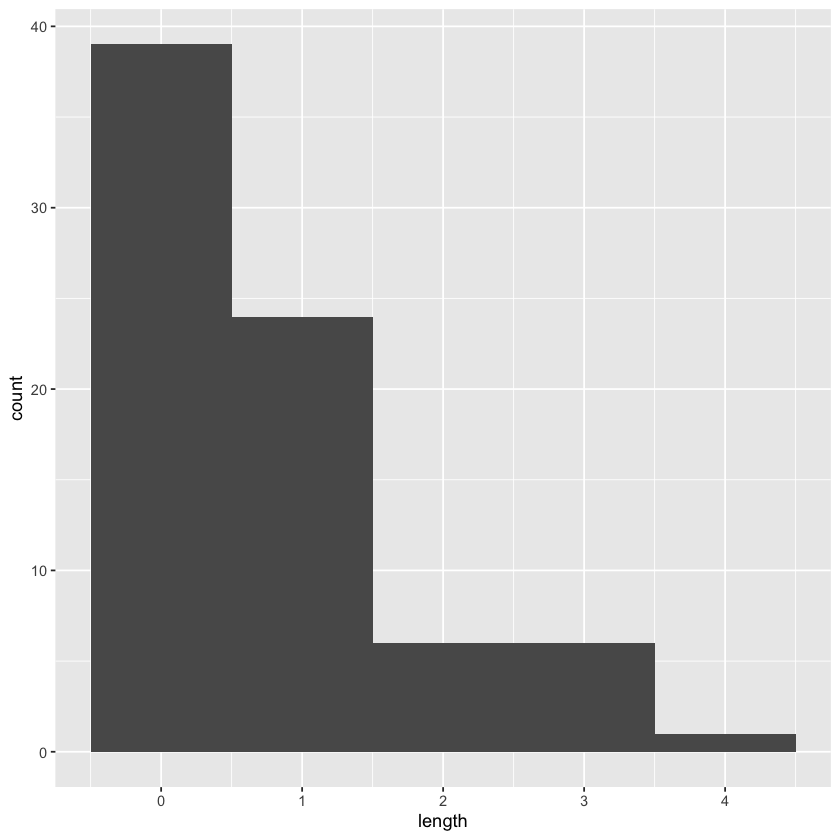

In [8]:
ggplot(data = kobe_streak, aes(x = length)) +
  geom_histogram(binwidth = 1)

3.  Which of the following is false about the distribution of Kobe's streak lengths 
from the 2009 NBA finals. 
<ol>
<li> The distribution of Kobe's streaks is unimodal and right skewed. </li> (T)
<li> The typical length of a streak is 0 since the median of the distribution is at 0. </li> (T)
<li> The IQR of the distribution is 1. (T)
<li> The longest streak of baskets is of length 4. </li> (T)
<li> The shortest streak is of length 1.</li> (F)
</ol>

In [11]:
kobe_streak %>%
  summarise(median_dd = median(length), IQR_dd = IQR(length))

median_dd,IQR_dd
<dbl>,<dbl>
0,1


## Compared to What?

We've shown that Kobe had some long shooting streaks, but are they long enough 
to support the belief that he had hot hands? What can we compare them to?

To answer these questions, let's return to the idea of *independence*. Two 
processes are independent if the outcome of one process doesn't effect the outcome 
of the second. If each shot that a player takes is an independent process, 
having made or missed your first shot will not affect the probability that you
will make or miss your second shot.

A shooter with a hot hand will have shots that are *not* independent of one 
another. Specifically, if the shooter makes his first shot, the hot hand model 
says he will have a *higher* probability of making his second shot.

Let's suppose for a moment that the hot hand model is valid for Kobe. During his
career, the percentage of time Kobe makes a basket (i.e. his shooting 
percentage) is about 45%, or in probability notation,

\[ P(\textrm{shot 1 = H}) = 0.45 \]

If he makes the first shot and has a hot hand (*not* independent shots), then 
the probability that he makes his second shot would go up to, let's say, 60%,

\[ P(\textrm{shot 2 = H} \, | \, \textrm{shot 1 = H}) = 0.60 \]

As a result of these increased probabilites, you'd expect Kobe to have longer 
streaks. Compare this to the skeptical perspective where Kobe does *not* have a
hot hand, where each shot is independent of the next. If he hit his first shot,
the probability that he makes the second is still 0.45.

\[ P(\textrm{shot 2 = H} \, | \, \textrm{shot 1 = H}) = 0.45 \]

In other words, making the first shot did nothing to effect the probability that
he'd make his second shot. If Kobe's shots are independent, then he'd have the 
same probability of hitting every shot regardless of his past shots: 45%.

Now that we've phrased the situation in terms of independent shots, let's return
to the question: how do we tell if Kobe's shooting streaks are long enough to 
indicate that he has hot hands? We can compare his streak lengths to someone
without hot hands: an independent shooter. 

## Simulations in R

While we don't have any data from a shooter we know to have independent shots, 
that sort of data is very easy to simulate in R. In a simulation, you set the 
ground rules of a random process and then the computer uses random numbers to 
generate an outcome that adheres to those rules. As a simple example, you can
simulate flipping a fair coin with the following.

In [1]:
coin_outcomes <- c("heads", "tails")
sample(coin_outcomes, size = 1, replace = TRUE)

[1] "heads"

The vector `outcomes` can be thought of as a hat with two slips of paper in it: 
one slip says `heads` and the other says `tails`. The function `sample` draws 
one slip from the hat and tells us if it was a head or a tail. 

Run the second command listed above several times. Just like when flipping a 
coin, sometimes you'll get a heads, sometimes you'll get a tails, but in the 
long run, you'd expect to get roughly equal numbers of each.

In [2]:
coin_outcomes <- c("heads", "tails")
sample(coin_outcomes, size = 1, replace = TRUE)

[1] "heads"

In [3]:
coin_outcomes <- c("heads", "tails")
sample(coin_outcomes, size = 1, replace = TRUE)

[1] "heads"

In [4]:
coin_outcomes <- c("heads", "tails")
sample(coin_outcomes, size = 1, replace = TRUE)

[1] "tails"

If you wanted to simulate flipping a fair coin 100 times, you could either run 
the function 100 times or, more simply, adjust the `size` argument, which 
governs how many samples to draw (the `replace = TRUE` argument indicates we put
the slip of paper back in the hat before drawing again). Save the resulting 
vector of heads and tails in a new object called `sim_fair_coin`.

In [5]:
sim_fair_coin <- sample(coin_outcomes, size = 100, replace = TRUE)

To view the results of this simulation, type the name of the object and then use
`table` to count up the number of heads and tails.

In [6]:
sim_fair_coin
table(sim_fair_coin)

[1] "heads" "tails" "tails" "tails" "tails" "heads" "tails" "tails" "tails"
 [10] "heads" "tails" "heads" "heads" "tails" "tails" "tails" "tails" "tails"
 [19] "tails" "heads" "tails" "heads" "heads" "heads" "tails" "heads" "heads"
 [28] "heads" "heads" "tails" "heads" "tails" "tails" "tails" "tails" "heads"
 [37] "tails" "tails" "tails" "tails" "tails" "heads" "tails" "heads" "heads"
 [46] "heads" "tails" "heads" "heads" "heads" "tails" "tails" "tails" "heads"
 [55] "tails" "heads" "heads" "heads" "heads" "heads" "tails" "heads" "tails"
 [64] "heads" "heads" "heads" "tails" "heads" "tails" "tails" "heads" "heads"
 [73] "tails" "heads" "tails" "heads" "heads" "heads" "tails" "tails" "heads"
 [82] "tails" "tails" "heads" "heads" "heads" "heads" "tails" "heads" "heads"
 [91] "heads" "tails" "tails" "tails" "heads" "tails" "heads" "tails" "tails"
[100] "tails"

sim_fair_coin
heads tails 
   49    51 

Since there are only two elements in `outcomes`, the probability that we "flip" 
a coin and it lands heads is 0.5. Say we're trying to simulate an unfair coin 
that we know only lands heads 20% of the time. We can adjust for this by adding 
an argument called `prob`, which provides a vector of two probability weights.

In [7]:
sim_unfair_coin <- sample(coin_outcomes, size = 100, replace = TRUE, 
                          prob = c(0.2, 0.8))

`prob = c(0.2, 0.8)` indicates that for the two elements in the `outcomes` vector,
we want to select the first one, `heads`, with probability 0.2 and the second 
one, `tails` with probability 0.8. Another way of thinking about this is to 
think of the outcome space as a bag of 10 chips, where 2 chips are labeled 
"head" and 8 chips "tail". Therefore at each draw, the probability of drawing a 
chip that says "head"" is 20%, and "tail" is 80%.

<div id="exercise">
**Exercise**: In your simulation of flipping the unfair coin 100 times, how many flips came up heads?
</div>

In [9]:
sim_unfair_coin
table(sim_unfair_coin)

[1] "tails" "tails" "tails" "tails" "tails" "tails" "tails" "heads" "tails"
 [10] "tails" "tails" "tails" "heads" "tails" "tails" "tails" "heads" "tails"
 [19] "tails" "tails" "tails" "tails" "heads" "tails" "tails" "tails" "tails"
 [28] "tails" "tails" "tails" "tails" "tails" "tails" "tails" "tails" "tails"
 [37] "tails" "tails" "heads" "heads" "tails" "tails" "heads" "tails" "heads"
 [46] "heads" "tails" "tails" "tails" "tails" "tails" "tails" "tails" "tails"
 [55] "tails" "heads" "heads" "tails" "tails" "tails" "tails" "tails" "heads"
 [64] "tails" "tails" "heads" "heads" "tails" "tails" "tails" "tails" "tails"
 [73] "tails" "tails" "tails" "tails" "tails" "tails" "tails" "tails" "tails"
 [82] "tails" "tails" "tails" "tails" "tails" "tails" "heads" "heads" "tails"
 [91] "heads" "heads" "tails" "heads" "tails" "tails" "tails" "tails" "tails"
[100] "tails"

sim_unfair_coin
heads tails 
   19    81 

In a sense, we've shrunken the size of the slip of paper that says "heads", 
making it less likely to be drawn and we've increased the size of the slip of 
paper saying "tails", making it more likely to be drawn. When we simulated the 
fair coin, both slips of paper were the same size. This happens by default if 
you don't provide a `prob` argument; all elements in the `outcomes` vector have 
an equal probability of being drawn.

If you want to learn more about `sample` or any other function, recall that you 
can always check out its help file with `?sample`.

In [10]:
?sample

## Simulating the Independent Shooter

Simulating a basketball player who has independent shots uses the same mechanism 
that we use to simulate a coin flip. To simulate a single shot from an 
independent shooter with a shooting percentage of 50% we type,

In [25]:
shot_outcomes <- c("H", "M")
sim_basket <- sample(shot_outcomes, size = 1, replace = TRUE)

To make a valid comparison between Kobe and our simulated independent shooter, 
we need to align both their shooting percentage and the number of attempted shots.


<div id="exercise">
**Exercise**: What change needs to be made to the `sample` function so that it reflects a shooting percentage of 45%? Make this adjustment, then run a simulation to sample 133 shots. Assign the output of this simulation to a new object called `sim_basket`.
</div>

In [29]:
shot_outcomes <- c("H", "M")
sim_basket <- sample(shot_outcomes, size = 133, replace = TRUE, 
                     prob = c(0.45, 0.55))
sim_basket

[1] "M" "M" "M" "M" "H" "M" "M" "H" "H" "H" "M" "H" "H" "M" "H" "H" "M" "H"
 [19] "M" "H" "H" "M" "M" "H" "H" "H" "M" "M" "M" "H" "M" "M" "M" "H" "M" "H"
 [37] "H" "M" "M" "H" "M" "H" "H" "M" "M" "H" "M" "M" "M" "M" "M" "M" "M" "M"
 [55] "M" "H" "M" "M" "H" "H" "M" "M" "H" "H" "H" "M" "M" "M" "M" "M" "M" "M"
 [73] "M" "H" "H" "M" "H" "M" "H" "M" "M" "M" "M" "M" "M" "M" "H" "M" "H" "M"
 [91] "H" "H" "M" "H" "M" "M" "M" "M" "H" "M" "H" "H" "M" "M" "H" "M" "M" "H"
[109] "M" "H" "H" "M" "M" "M" "H" "M" "M" "H" "H" "M" "M" "M" "M" "M" "M" "M"
[127] "H" "M" "M" "M" "H" "H" "M"

In [27]:
table(sim_basket)

sim_basket
 H  M 
47 86 

Comparison

In [46]:
kobe_basket$shot

[1] "H" "M" "M" "H" "H" "M" "M" "M" "M" "H" "H" "H" "M" "H" "H" "M" "M" "H"
 [19] "H" "H" "M" "M" "H" "M" "H" "H" "H" "M" "M" "M" "M" "M" "M" "H" "M" "H"
 [37] "M" "M" "H" "H" "H" "H" "M" "H" "M" "M" "H" "M" "M" "H" "M" "M" "H" "M"
 [55] "H" "H" "M" "M" "H" "M" "H" "H" "M" "H" "M" "M" "M" "H" "M" "M" "M" "M"
 [73] "H" "M" "H" "M" "M" "H" "M" "M" "H" "H" "M" "M" "M" "M" "H" "H" "H" "M"
 [91] "M" "H" "M" "M" "H" "M" "H" "H" "M" "H" "M" "M" "H" "M" "M" "M" "H" "M"
[109] "H" "H" "H" "M" "H" "H" "H" "M" "H" "M" "H" "M" "M" "M" "M" "M" "M" "H"
[127] "M" "H" "M" "M" "M" "M" "H"

In [47]:
table(kobe_basket$shot)


 H  M 
58 75 

Note that we've named the new vector `sim_basket`, the same name that we gave to
the previous vector reflecting a shooting percentage of 50%. In this situation, 
R overwrites the old object with the new one, so always make sure that you don't
need the information in an old vector before reassigning its name.

With the results of the simulation saved as `sim_basket`, we have the data 
necessary to compare Kobe to our independent shooter.

Both data sets represent the results of 133 shot attempts, each with the same 
shooting percentage of 45%. We know that our simulated data is from a shooter 
that has independent shots. That is, we know the simulated shooter does not have
a hot hand.

### Comparing Kobe Bryant to the Independent Shooter

<div id="exercise">
**Exercise**: Using `calc_streak`, compute the streak lengths of `sim_basket`, and save the results in a data frame called `sim_streak`. Note that since the `sim_streak` object is just a vector and not a variable in a data frame, we don't need to first select it from a data frame like we did earlier when we calculated the streak lengths for Kobe's shots.
</div>

In [48]:
sim_streak <- calc_streak(sim_basket)

<div id="exercise">
**Exercise**: Make a plot of the distribution of simulated streak lengths of the independent shooter. What is the typical streak length for this simulated independent shooter with a 45% shooting percentage? How long is the player's longest streak of baskets in 133 shots?
</div>

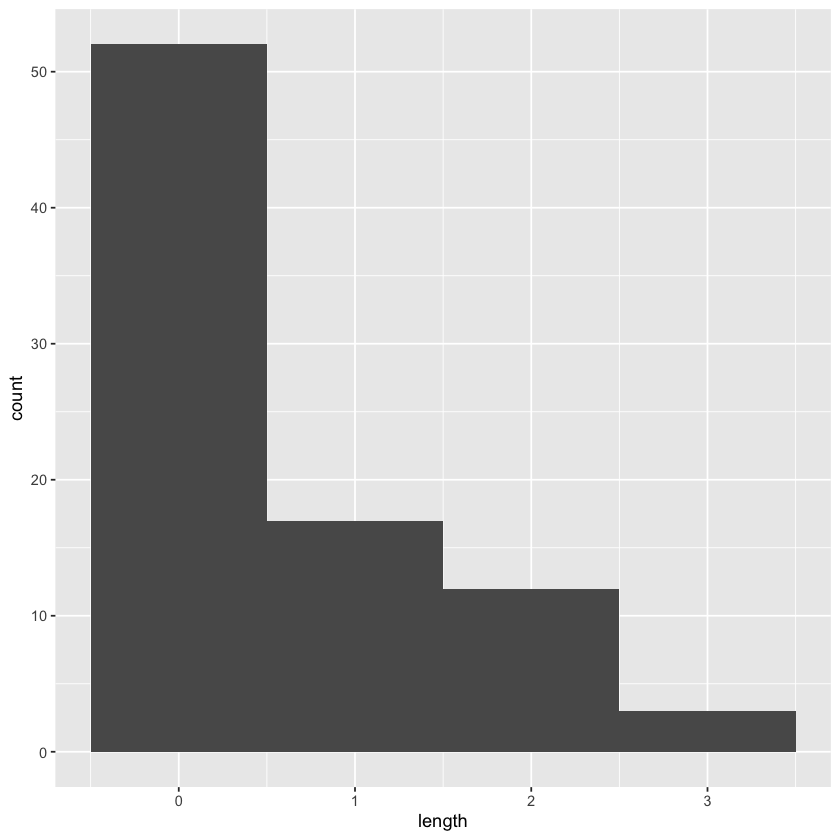

In [50]:
ggplot(data = sim_streak, aes(x = length)) +
  geom_histogram(binwidth = 1)


4.  If you were to run the simulation of the independent shooter a second time, how 
would you expect its streak distribution to compare to the distribution from the 
exercise above? 
<ol>
<li> Exactly the same  </li>
<li> Somewhat similar </li>
<li> Totally different </li>
</ol>


5.  How does Kobe Bryant's distribution of streak lengths compare to the distribution 
of streak lengths for the simulated shooter? Using this comparison, do you have 
evidence that the hot hand model fits Kobe's shooting patterns?
<ol>
<li> The distributions look very similar. Therefore, there doesn't appear to be evidence for Kobe Bryant's hot hand. </li>
<li> The distributions look very similar. Therefore, there appears to be evidence for Kobe Bryant's hot hand. </li>
<li> The distributions look very different. Therefore, there doesn't appear to be evidence for Kobe Bryant's hot hand. </li>
<li> The distributions look very different. Therefore, there appears to be evidence for Kobe Bryant's hot hand. </li>
</ol>

<div id="exercise">
**Exercise**: What concepts from the course videos are covered in this lab? What 
concepts, if any, are not covered in the videos? Have you seen these concepts 
elsewhere, e.g. textbook, previous labs, or practice problems?
</div>

<div id="license">
This is a derivative of an [OpenIntro](https://www.openintro.org/stat/labs.php) lab, and is released under a [Attribution-NonCommercial-ShareAlike 3.0 United States](https://creativecommons.org/licenses/by-nc-sa/3.0/us/) license.
</div>